In [1]:
import xgboost
import re, gc, os
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mode
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from datetime import datetime

from preprocessing_script import frequency_encode, sizeof_fmt

pd.set_option("display.max_columns", 500)

NB_VENUES = 6
MICROSEC = int(1e6)
MIN_PER_HOUR = 60
SEC_PER_MIN = 60
TARGET = "source_id"
FEATURES_LIST = list()
BASE_DATA_PATH = "./input/make-features-cfm/"

print(f"Kernel lancé le : {datetime.now().strftime('%d %b, %H h %M')}")

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.0 requires scipy==1.4.1, but you'll have scipy 1.6.0 which is incompatible.
kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
kmeans-smote 0.1.2 requires scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.23.2 which is incompatible.
dask-xgboost 0.1.11 requires xgboost<=0.90, but you'll have xgboost 1.2.0 which is incompatible

1.4.1
Kernel lancé le : 20 Jan, 17 h 36


In [2]:
number_kf = 5
n_est = 1500
lr = 0.05
early_stopping = 250

params = {"n_estimators": n_est,
          "verbosity": 1,
          "learning_rate": lr,
          "objective": "multi:softmax",
          "num_class": 6,
          "max_depth": 8,
          "colsample_bytree": 0.6,
          "tree_method": 'gpu_hist',
          # "gamma": 3, #worsens the score
          "min_child_weight": 4,  # little improvement w/ 0.3
          # "max_delta_step": 3, # no improvement
          # "sampling_method": "gradient_based" # no improvement
          }

In [3]:
train_data = pd.read_csv(os.path.join(BASE_DATA_PATH, "train_data.csv")).drop("Unnamed: 0", axis=1)
test_data  = pd.read_csv(os.path.join(BASE_DATA_PATH, "test_data.csv"), usecols=["stock_id", "day_id", "trade_quarter"])

train_data.shape, test_data.shape

((946657, 271), (953897, 3))

In [4]:
# Type casting to save memory

col_types = {c: np.int8 for c in train_data.columns if "_source_id" in c}
col_types.update({c: np.int8 for c in train_data.columns if "past_venues" in c})
col_types.update({c: np.float32 for c in train_data.columns if "rank" in c})

for col, dtype in col_types.items():
    try:
        train_data[col] = train_data[col].astype(dtype)
    except ValueError:
        if dtype == np.int8:
            train_data[col] = train_data[col].astype(np.float64)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946657 entries, 0 to 946656
Columns: 271 entries, OB_ask_0 to venue_stockday_5
dtypes: float32(30), float64(185), int64(34), int8(22)
memory usage: 1.7 GB


In [6]:
train_data["stock_hour"] = (train_data["stock_id"].astype(str) + "_" + train_data["trade_quarter"].astype(str)).astype("category")
test_data ["stock_hour"] = (test_data["stock_id"].astype(str)  + "_" + test_data ["trade_quarter"].astype(str)).astype("category")

In [7]:
train_data.head(2)

,OB_ask_0,OB_ask1_0,OB_ask_size_0,OB_ask_size1_0,OB_bid_0,OB_bid1_0,OB_bid_size_0,OB_bid_size1_0,trade_price_0,trade_qty_0,trade_source_id_0,trade_tod_0,OB_ts_last_update_0,OB_ask_1,OB_ask1_1,OB_ask_size_1,OB_ask_size1_1,OB_bid_1,OB_bid1_1,OB_bid_size_1,OB_bid_size1_1,OB_ts_last_update_1,OB_ask_2,OB_ask1_2,OB_ask_size_2,OB_ask_size1_2,OB_bid_2,OB_bid1_2,OB_bid_size_2,OB_bid_size1_2,OB_ts_last_update_2,OB_ask_3,OB_ask1_3,OB_ask_size_3,OB_ask_size1_3,OB_bid_3,OB_bid1_3,OB_bid_size_3,OB_bid_size1_3,OB_ts_last_update_3,OB_ask_4,OB_ask1_4,OB_ask_size_4,OB_ask_size1_4,OB_bid_4,OB_bid1_4,OB_bid_size_4,OB_bid_size1_4,OB_ts_last_update_4,OB_ask_5,OB_ask1_5,OB_ask_size_5,OB_ask_size1_5,OB_bid_5,OB_bid1_5,OB_bid_size_5,OB_bid_size1_5,OB_ts_last_update_5,trade_price_1,trade_qty_1,trade_source_id_1,trade_tod_1,trade_price_2,trade_qty_2,trade_source_id_2,trade_tod_2,trade_price_3,trade_qty_3,trade_source_id_3,trade_tod_3,trade_price_4,trade_qty_4,trade_source_id_4,trade_tod_4,trade_price_5,trade_qty_5,trade_source_id_5,trade_tod_5,trade_price_6,trade_qty_6,trade_source_id_6,trade_tod_6,trade_price_7,trade_qty_7,trade_source_id_7,trade_tod_7,trade_price_8,trade_qty_8,trade_source_id_8,trade_tod_8,trade_price_9,trade_qty_9,trade_source_id_9,trade_tod_9,stock_id,day_id,source_id,trade_quarter,trade_minute,nb_0_5past_venues,nb_1_5past_venues,nb_2_5past_venues,nb_3_5past_venues,nb_4_5past_venues,nb_5_5past_venues,nb_0_10past_venues,nb_1_10past_venues,nb_2_10past_venues,nb_3_10past_venues,nb_4_10past_venues,nb_5_10past_venues,ask_size_0,bid_size_0,total_size_0,ask_size_1,bid_size_1,total_size_1,ask_size_2,bid_size_2,total_size_2,ask_size_3,bid_size_3,total_size_3,ask_size_4,bid_size_4,total_size_4,ask_size_5,bid_size_5,total_size_5,weighted_bid_OB_price_0,weighted_ask_OB_price_0,weighted_bid_OB_price_1,weighted_ask_OB_price_1,weighted_bid_OB_price_2,weighted_ask_OB_price_2,weighted_bid_OB_price_3,weighted_ask_OB_price_3,weighted_bid_OB_price_4,weighted_ask_OB_price_4,weighted_bid_OB_price_5,weighted_ask_OB_price_5,OB_ask_0_rank,OB_ask_1_rank,OB_ask_2_rank,OB_ask_3_rank,OB_ask_4_rank,OB_ask_5_rank,OB_bid_0_rank,OB_bid_1_rank,OB_bid_2_rank,OB_bid_3_rank,OB_bid_4_rank,OB_bid_5_rank,OB_ts_last_update_0_rank,OB_ts_last_update_1_rank,OB_ts_last_update_2_rank,OB_ts_last_update_3_rank,OB_ts_last_update_4_rank,OB_ts_last_update_5_rank,weighted_ask_OB_price_0_rank,weighted_ask_OB_price_1_rank,weighted_ask_OB_price_2_rank,weighted_ask_OB_price_3_rank,weighted_ask_OB_price_4_rank,weighted_ask_OB_price_5_rank,weighted_bid_OB_price_0_rank,weighted_bid_OB_price_1_rank,weighted_bid_OB_price_2_rank,weighted_bid_OB_price_3_rank,weighted_bid_OB_price_4_rank,weighted_bid_OB_price_5_rank,num_lasttrades_ask_side,mean_lasttrades_price,std_lasttrades_price,min_lasttrades_price,max_lasttrades_price,mean_lasttrades_qty,std_lasttrades_qty,min_lasttrades_qty,max_lasttrades_qty,std_lasttrades_time,normalized_OB_ask_0,normalized_OB_ask_1,normalized_OB_ask_2,normalized_OB_ask_3,normalized_OB_ask_4,normalized_OB_ask_5,normalized_OB_ask1_0,normalized_OB_ask1_1,normalized_OB_ask1_2,normalized_OB_ask1_3,normalized_OB_ask1_4,normalized_OB_ask1_5,normalized_OB_bid_0,normalized_OB_bid_1,normalized_OB_bid_2,normalized_OB_bid_3,normalized_OB_bid_4,normalized_OB_bid_5,normalized_OB_bid1_0,normalized_OB_bid1_1,normalized_OB_bid1_2,normalized_OB_bid1_3,normalized_OB_bid1_4,normalized_OB_bid1_5,ratio_01_ask1?__0,ratio_01_ask1?__1,ratio_01_ask1?__2,ratio_01_ask1?__3,ratio_01_ask1?__4,ratio_01_ask1?__5,ratio_01_bid1?__0,ratio_01_bid1?__1,ratio_01_bid1?__2,ratio_01_bid1?__3,ratio_01_bid1?__4,ratio_01_bid1?__5,ratio_01_ask_size1?__0,ratio_01_ask_size1?__1,ratio_01_ask_size1?__2,ratio_01_ask_size1?__3,ratio_01_ask_size1?__4,ratio_01_ask_size1?__5,ratio_01_bid_size1?__0,ratio_01_bid_size1?__1,ratio_01_bid_size1?__2,ratio_01_bid_size1?__3,ratio_01_bid_size1?__4,ratio_01_bid_size1?__5,OB_ask_0_sum_norm,OB_ask_1_sum_norm,OB_ask_2_sum_norm,OB_ask_3_sum_norm,OB_ask_4_sum_norm,OB_ask_5_sum_norm,OB_bid

In [8]:
FEATURES_LIST = list(train_data.columns)

feats_to_remove = ["stock_hour", "trade_quarter", "trade_minute", "stock_id", "day_id", "source_id", "Unnamed: 0"] \
                + [c for c in train_data.columns if re.match(r"trade_source_id_[4-9]", c)] \
                + ["price_bestprice_trade", "max_lasttrades_price"]  # correlated features

FEATURES_LIST = [f for f in FEATURES_LIST if f not in feats_to_remove]

FEATURES_LIST = list(set(FEATURES_LIST))
print(f"Number of features used: {len(FEATURES_LIST)}")
print(f"Unused columns : {sorted(set(train_data.columns).difference(set(FEATURES_LIST)))}")

Number of features used: 259
Unused columns : ['day_id', 'max_lasttrades_price', 'source_id', 'stock_hour', 'stock_id', 'trade_minute', 'trade_quarter', 'trade_source_id_4', 'trade_source_id_5', 'trade_source_id_6', 'trade_source_id_7', 'trade_source_id_8', 'trade_source_id_9']


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946657 entries, 0 to 946656
Columns: 272 entries, OB_ask_0 to stock_hour
dtypes: category(1), float32(30), float64(185), int64(34), int8(22)
memory usage: 1.7 GB


In [10]:
def smoothed_target_encoding(count_sources: pd.Series, overall_count: pd.Series, min_smoothing: float=0.1):
    """Simple formula to smooth target encoding when cardinal of the group is small
    """
    categ_card = count_sources.shape[0]
    raw_TE = count_sources.value_counts() / categ_card
    smooth_term = min(1 / (2 * np.sqrt(categ_card / 100)), 1 - min_smoothing)
    final_TE = ((1 - smooth_term) * raw_TE).add(smooth_term * overall_count, fill_value=0)
    #final_TE = (1 - smooth_term) * raw_TE + smooth_term * overall_count
    
    return final_TE

In [11]:
kfolds = KFold(n_splits=number_kf)
days_ids = train_data["day_id"].unique()

features_encoding_mappings = list()
predictions = list()
feat_imp = list()
scores = list()
models = dict()

print("Begin training... \n")

for i, (days_index_entr, days_index_val) in enumerate(kfolds.split(days_ids)):
    print("_" * 30 + f"\nFold-{i + 1}")
    
    train_data_entr = train_data[train_data["day_id"].isin(days_ids[days_index_entr])]
    train_data_val  = train_data[train_data["day_id"].isin(days_ids[days_index_val])]
    
    print("Encoding variables...")
    variables_to_encode = ["stock_id", "trade_quarter"]
    encodings, new_feats = frequency_encode(variables_to_encode, train_data_entr, [train_data_val, test_data])
    features_encoding_mappings.append(encodings)
    FEATURES_LIST.extend(new_feats)

    for encoded_var in encodings.keys():
        train_data_entr = train_data_entr.join(encodings[encoded_var], on=encoded_var)
        train_data_val  = train_data_val .join(encodings[encoded_var], on=encoded_var)
        test_data = test_data.join(encodings[encoded_var], on=encoded_var)
        
        
    overall_count = train_data_entr.source_id.value_counts() / train_data_entr.shape[0]
    stock_hour_encoding = (train_data_entr.groupby('stock_hour')["source_id"]
                                          .apply(lambda feat_count: smoothed_target_encoding(feat_count, 
                                                                                   overall_count, 
                                                                                   min_smoothing=0.1)))

    TE_mapping = stock_hour_encoding.unstack().to_dict(orient="series")

    for venue in range(NB_VENUES):
        train_data_entr[f"FE_stock_hour_{venue}"] = train_data_entr["stock_hour"].map(TE_mapping[venue])
        train_data_val [f"FE_stock_hour_{venue}"] = train_data_val ["stock_hour"].map(TE_mapping[venue])
        test_data[f"FE_stock_hour_{venue}"] = test_data["stock_hour"].map(TE_mapping[venue])
        

    print("Encoding done!")

    if i == 0: print(f"{len(FEATURES_LIST)} variables used")
    
    xgb = xgboost.XGBClassifier(**params)

    xgb.fit(train_data_entr[FEATURES_LIST], 
            train_data_entr[TARGET], 
            eval_set=[(train_data_val[FEATURES_LIST], 
                       train_data_val[TARGET])],
            verbose=early_stopping,
            early_stopping_rounds=n_est // 10,
           )
    
    y_pred = xgb.predict(train_data_val[FEATURES_LIST])

    score = accuracy_score(train_data_val[TARGET], y_pred)
    print(f"\nVal Accuracy = {score:.4f}")

    feat_imp.append(xgb.feature_importances_)
    scores.append(score)
    models[f"fold_{i}"] = xgb
    
    test_data[[c for c in test_data.columns if "FE_" in c]].to_csv(f"FE_fold{i}.csv")
    test_data = test_data.drop([c for c in test_data.columns if "FE_" in c], axis=1)


folds_score = sum(scores) / number_kf
print(f"\nTotal validation score for {number_kf} folds = {folds_score:.4f}")

Begin training... 

______________________________
Fold-1
Encoding variables...
Encoding done!
271 variables used
[0]	validation_0-merror:0.50231
Will train until validation_0-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.48694
[500]	validation_0-merror:0.48666
Stopping. Best iteration:
[484]	validation_0-merror:0.48657


Val Accuracy = 0.5134
______________________________
Fold-2
Encoding variables...
Encoding done!
[0]	validation_0-merror:0.50371
Will train until validation_0-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.48681
[500]	validation_0-merror:0.48646
Stopping. Best iteration:
[503]	validation_0-merror:0.48631


Val Accuracy = 0.5137
______________________________
Fold-3
Encoding variables...
Encoding done!
[0]	validation_0-merror:0.50295
Will train until validation_0-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.48868
[500]	validation_0-merror:0.48867
Stopping. Best iteration:
[391]	validation_0-merror:0.48797


Va

In [12]:
print("Feature Importance by group of features")

mean_feat_imp = np.array(feat_imp).mean(axis=0)

df_imp = pd.DataFrame(zip(FEATURES_LIST, mean_feat_imp))
df_imp['big_feat'] = df_imp[0].apply(lambda x: "".join([c for c in x if not c.isdigit()]))
 
(df_imp
 .groupby("big_feat")
 .sum()
 .sort_values(by=1, ascending=False)
 .T
 .style
 .format("{:.3%}")
 .background_gradient(cmap=sns.light_palette("green", as_cmap=True), axis=1)
)

Feature Importance by group of features


big_feat,last_trades__.,OB_ask__rank,OB_bid__rank,nb__past_venues,normalized_OB_ask_,normalized_OB_bid_,OB_bid_,venue_stockday_,OB_ask_,OB_ask__sum_norm,OB_bid__sum_norm,venue_FE_stock_id_,trade_price_,OB_ts_last_update__rank,OB_ask_size_,OB_bid_size_,trade_tod_,trade_qty_,weighted_bid_OB_price__rank,weighted_ask_OB_price__rank,OB_ts_last_update_,trade_source_id_,venue_FE_trade_quarter_,weighted_bid_OB_price_,weighted_ask_OB_price_,ratio__bid?__,OB_ts_last_update__sum_norm,ratio__ask?__,total_size_,ratio__ask_size?__,ask_size_,bid_size_,ratio__bid_size?__,mean_lasttrades_qty,num_lasttrades_ask_side,min_lasttrades_price,mean_lasttrades_price,max_lasttrades_qty,std_lasttrades_price,std_lasttrades_time,std_lasttrades_qty,min_lasttrades_qty
1,16.981%,9.681%,9.385%,8.061%,5.686%,5.606%,4.514%,4.339%,3.658%,3.585%,3.432%,2.359%,2.261%,1.468%,1.376%,1.374%,1.369%,1.285%,1.106%,1.019%,0.967%,0.946%,0.898%,0.892%,0.869%,0.768%,0.733%,0.724%,0.694%,0.673%,0.673%,0.667%,0.664%,0.207%,0.183%,0.170%,0.137%,0.130%,0.120%,0.117%,0.114%,0.110%


In [13]:
print("Feature Importance")

for feat, imp in sorted(zip(FEATURES_LIST, mean_feat_imp), key=lambda x: x[1], reverse=True):
    print(f"{feat:<35} {imp:.2%}")

Feature Importance
last_trades_3_0.0100                6.72%
OB_bid_4_rank                       3.76%
OB_ask_4_rank                       3.06%
last_trades_3_0.1000                2.98%
venue_stockday_2                    2.53%
OB_bid_5_rank                       2.22%
OB_ask_2_rank                       2.21%
OB_ask_5_rank                       1.99%
nb_3_5past_venues                   1.98%
OB_ask_1_rank                       1.76%
OB_bid_1_rank                       1.66%
normalized_OB_bid_2                 1.60%
OB_bid_3                            1.50%
OB_ask_3                            1.47%
OB_ask_4_sum_norm                   1.36%
normalized_OB_ask_2                 1.34%
OB_bid1_3                           1.29%
last_trades_1_1.0000                1.15%
OB_bid_2_rank                       1.11%
venue_FE_stock_id_4                 1.07%
normalized_OB_ask_3                 1.05%
normalized_OB_bid_3                 1.04%
trade_price_0                       1.01%
OB_bid_4_sum_no

Building confusion matrix


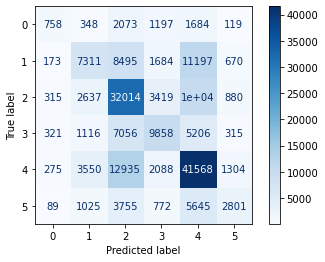

In [14]:
print("Building confusion matrix")
plot_confusion_matrix(xgb, train_data_val[FEATURES_LIST], train_data_val[TARGET],
                         #display_labels=class_names,
                         cmap=plt.cm.Blues)

In [15]:
print("Save models...")

for k, fold_number in enumerate(models.keys()):
    print(f"Fold n°{fold_number}")
    file_name = f"xgb_model_{k}.pkl"
    pickle.dump(models[fold_number], open(file_name, "wb"))

Save models...
Fold n°fold_0
Fold n°fold_1
Fold n°fold_2
Fold n°fold_3
Fold n°fold_4


In [16]:
print(f"Number of variables = {train_data.shape[1]}")
print(f"XGB Parameters used = {params}")

Number of variables = 272
XGB Parameters used = {'n_estimators': 1500, 'verbosity': 1, 'learning_rate': 0.05, 'objective': 'multi:softmax', 'num_class': 6, 'max_depth': 8, 'colsample_bytree': 0.6, 'tree_method': 'gpu_hist', 'min_child_weight': 4}


In [17]:
print("Saving folds frequency encoding...")

for k, encodings in enumerate(features_encoding_mappings):
    for encoding in encodings.keys():
        encodings[encoding].to_csv(f"fold_{k}_{encoding}.csv")

Saving folds frequency encoding...


In [18]:
print("Save features list as pickle...")

with open('features_list.pkl', 'wb') as fp:
    pickle.dump(FEATURES_LIST, fp)

Save features list as pickle...
